# SINDy-SHRED: Synthetic Data Example

This notebook demonstrates SINDy-SHRED on a synthetic toy dataset using the `SINDySHRED` class. The class handles data preprocessing, model training, and post-hoc SINDy discovery automatically.

## Overview

**SHRED** (SHallow REcurrent Decoder) models combine a recurrent layer (GRU) with a shallow decoder network to reconstruct high-dimensional spatio-temporal fields from sensor measurements.

**SINDy-SHRED** extends this by integrating Sparse Identification of Nonlinear Dynamics (SINDy) to learn interpretable governing equations:

$$\dot{z} = \Theta(z) \xi$$

## Synthetic Data

The synthetic data uses the **FitzHugh-Nagumo Model** with spatially delayed copies:

$$\dot{v} = v - \frac{1}{3}v^3 - w + I_{ext}$$
$$\dot{w} = \frac{1}{\tau}(v + a - bw)$$

## Notebook Structure

1. Setup and Imports
2. Data Generation
3. Model Configuration and Training
4. SINDy Discovery
5. Evaluation
6. Save Results

## 1. Setup and Imports

In [1]:
import copy
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from scipy.integrate import solve_ivp

# Local modules
from sindy_shred import SINDySHRED
import plotting

warnings.filterwarnings("ignore")

# Create results directory
RESULTS_DIR = "results/synthetic_data"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_DIR}")

/home/mars/sindy-shred/sindyshred/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


Results will be saved to: results/synthetic_data


### Device and Seed Configuration

In [2]:
# Device selection
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using device: {device}")

# Set seeds for reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed(SEED)

Using device: cuda


### Plotting Configuration

In [3]:
sns.set_context("paper")
sns.set_style("whitegrid")

pcolor_kwargs = {
    "vmin": -3,
    "vmax": 3,
    "cmap": "RdBu_r",
    "rasterized": True,
}

## 2. Data Generation

Generate synthetic spatio-temporal data from the FitzHugh-Nagumo model with spatially delayed copies.

### Define Dynamical System

In [4]:
def rhs_FNM(t, x, tau, a, b, Iext):
    """FitzHugh-Nagumo Model.
    
    Parameters
    ----------
    t : float
        Time (unused, for ODE solver interface).
    x : array-like
        State vector [v, w].
    tau : float
        Time constant.
    a, b : float
        Model parameters.
    Iext : float
        External input current.
        
    Returns
    -------
    dx : array-like
        Time derivatives [dv/dt, dw/dt].
    """
    v, w = x
    vdot = v - (v**3) / 3 - w + Iext
    wdot = (1 / tau) * (v + a - b * w)
    return np.array([vdot, wdot])

### Generate Data

In [5]:
# Time integration parameters
T = 64
dt_solve = 0.0001 * 8
t_solution = np.arange(0, T, dt_solve)

# FitzHugh-Nagumo parameters
x0 = np.array([-1.110, -0.125])
tau1 = 2
a = 0.7
b = 0.8
Iext = 0.65

# Solve the ODE
solution_fn = solve_ivp(
    rhs_FNM, [0, T], x0, t_eval=t_solution, args=(tau1, a, b, Iext)
)

print(f"FitzHugh-Nagumo solution shape: {solution_fn.y.shape}")

FitzHugh-Nagumo solution shape: (2, 80000)


In [6]:
# Create spatially delayed copies
num_space_dims = 10
delays = np.linspace(0, 2, num_space_dims)  # delays in time units
uv_spatial = np.zeros((len(t_solution), 2 * num_space_dims))

for i in range(num_space_dims):
    delay_steps = int(delays[i] / dt_solve)
    if delay_steps == 0:
        uv_spatial[:, 2 * i : 2 * i + 2] = solution_fn.y.T
    else:
        # Pad with initial condition and shift
        uv_spatial[:, 2 * i : 2 * i + 2] = np.vstack(
            [np.tile(x0, (delay_steps, 1)), solution_fn.y.T[:-delay_steps, :]]
        )

# Subsample for computational efficiency
substep = 50
uv_spatial = uv_spatial[0::substep, :]
t_solution = t_solution[0::substep]
time = t_solution
dt_data = time[1] - time[0]

# Get dimensions
n_space_dims = uv_spatial.shape[1]
n_time = uv_spatial.shape[0]

# Final data matrix (space x time for visualization)
data_original = uv_spatial.T
space_dim = np.arange(n_space_dims)

print(f"Data shape (space x time): {data_original.shape}")
print(f"Time step: {dt_data:.6f}")
print(f"Number of time samples: {n_time}")
print(f"Spatial dimension: {n_space_dims}")

Data shape (space x time): (20, 1600)
Time step: 0.040000
Number of time samples: 1600
Spatial dimension: 20


### Visualize Generated Data

Saved data plot to results/synthetic_data/data_original.pdf


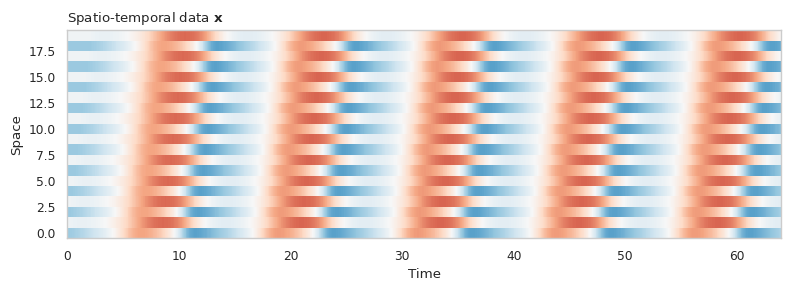

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.pcolormesh(time, space_dim, data_original, **pcolor_kwargs)
ax.set_title(r"Spatio-temporal data $\mathbf{x}$", loc="left")
ax.set_ylabel("Space")
ax.set_xlabel("Time")

fig.tight_layout()

# Save the data visualization plot
fig.savefig(f"{RESULTS_DIR}/data_original.pdf", bbox_inches="tight", dpi=300)
fig.savefig(f"{RESULTS_DIR}/data_original.png", bbox_inches="tight", dpi=300)
print(f"Saved data plot to {RESULTS_DIR}/data_original.pdf")

plt.show()

## 3. Model Configuration and Training

Configure the SINDy-SHRED model using the `SINDySHRED` class.

### Data Configuration

In [8]:
# Sensor configuration (fixed for reproducibility)
sensor_locations = np.array([5, 14, 7])
num_sensors = len(sensor_locations)

# Model hyperparameters
latent_dim = 2
poly_order = 3

# Data split configuration
lags = 120
train_length = 750 // 4
validate_length = 0

# Prepare data (transpose to time x space, subsample)
load_X = copy.deepcopy(data_original)
load_X = load_X.T[::4]  # Subsample
dt = dt_data * 4
lags = lags // 4
t_plot = time[::4]

# SINDy threshold
threshold = 0.0

print(f"Data shape after preprocessing: {load_X.shape}")
print(f"Number of sensors: {num_sensors}")
print(f"Latent dimension: {latent_dim}")
print(f"Trajectory length (lags): {lags}")
print(f"Training length: {train_length}")
print(f"Time step: {dt:.6f}")

Data shape after preprocessing: (400, 20)
Number of sensors: 3
Latent dimension: 2
Trajectory length (lags): 30
Training length: 187
Time step: 0.160000


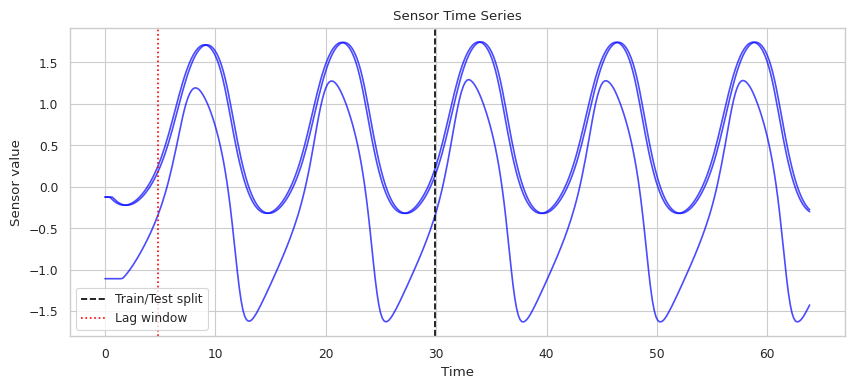

In [9]:
# Visualize sensor time series
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t_plot, load_X[:, sensor_locations], color='b', alpha=0.7)
ax.axvline(t_plot[train_length], color='k', linestyle='--', label='Train/Test split')
ax.axvline(t_plot[lags], color='r', linestyle=':', label='Lag window')
ax.set_xlabel('Time')
ax.set_ylabel('Sensor value')
ax.set_title('Sensor Time Series')
ax.legend()
plt.show()

### Initialize and Train Model

The `SINDySHRED` class handles data preprocessing and model training.

In [10]:
# Initialize the model
model = SINDySHRED(
    latent_dim=latent_dim, 
    poly_order=poly_order,
    ode_order=1,  # 1st order ODE: z' = f(z)
    num_epochs=600,
    verbose=True,
    device=device,
)

# Fit the model
model.fit(
    num_sensors,
    dt,
    load_X,
    lags,
    train_length,
    validate_length,
    sensor_locations
)

1 : tensor(0.3208, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.2461, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.2441, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.2183, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.2047, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.2016, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.2064, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.2004, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.1931, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.1909, device='cuda:

## 4. SINDy Discovery

Discover sparse governing equations from the learned latent space.

SINDy-derived dynamical equation (1st order):

(x0)' = -0.258 1 + 1.112 x0 + -1.176 x1 + 0.278 x0^2 + -0.061 x0 x1 + 0.108 x1^2 + -1.038 x0^3 + 1.399 x0^2 x1 + -1.043 x0 x1^2 + 0.477 x1^3
(x1)' = 0.005 1 + 0.498 x0 + -0.455 x1 + -0.127 x0^2 + 0.129 x0 x1 + -0.017 x1^2 + 0.113 x0^3 + 0.056 x0^2 x1 + -0.050 x0 x1^2 + 0.155 x1^3


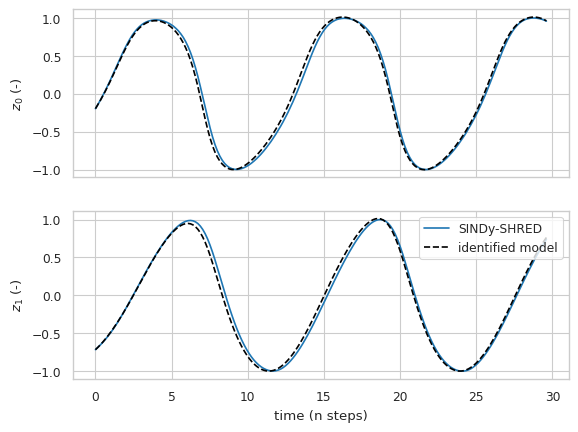

Saved latent comparison plot to results/synthetic_data/latent_comparison.png


In [11]:
# Perform SINDy identification with automatic plot saving
model.sindy_identify(
    threshold=threshold, 
    plot_result=True, 
    save_path=f"{RESULTS_DIR}/latent_comparison"
)
print(f"Saved latent comparison plot to {RESULTS_DIR}/latent_comparison.png")

### Auto-Tune Threshold (Adaptive/Nonparametric)

Alternatively, use `auto_tune_threshold()` to automatically determine the best threshold.
By default it uses a nonparametric approach:
1. First computes the least-squares solution (threshold=0)
2. Uses `scale_factor * max(|coefficients|)` as the max threshold
3. Tests `n_thresholds` evenly spaced values and picks the best stable model

In [12]:
# Auto-tune threshold using nonparametric approach
# This computes least-squares solution first, then determines threshold range adaptively
best_threshold, tune_results = model.auto_tune_threshold(
    adaptive=True,           # Use nonparametric approach (default)
    scale_factor=0.2,        # Max threshold = 0.3 * max(|coefficients|)
    n_thresholds=10,         # Test 10 evenly spaced thresholds
    metric="sparsity_stable", # Pick sparsest stable model
    verbose=True,
)

print(f"\nBest threshold: {best_threshold:.4f}")
print(f"Tested thresholds: {tune_results['thresholds']}")
print(f"Sparsity at each: {tune_results['sparsity']}")
print(f"Stability at each: {tune_results['stable']}")

Computing least-squares solution to determine threshold range...
Max |coefficient|: 1.3988
Max threshold (scale_factor=0.2): 0.2798
Testing 10 thresholds: [0.         0.03108475 0.0621695  0.09325425 0.124339   0.15542375
 0.1865085  0.21759325 0.248678   0.27976274]
Testing threshold=0.000... sparsity=20, stable, MSE=4.0066e-03
Testing threshold=0.031... sparsity=13, stable, MSE=2.5274e-04
Testing threshold=0.062... sparsity=13, stable, MSE=2.5274e-04
Testing threshold=0.093... sparsity=11, stable, MSE=3.1752e-03
Testing threshold=0.124... sparsity=6, stable, MSE=1.0475e-01
Testing threshold=0.155... sparsity=6, stable, MSE=1.0475e-01
Testing threshold=0.187... sparsity=6, stable, MSE=1.0475e-01
Testing threshold=0.218... sparsity=6, stable, MSE=1.0475e-01
Testing threshold=0.249... sparsity=6, stable, MSE=1.0475e-01
Testing threshold=0.280... sparsity=6, stable, MSE=1.0475e-01

Best threshold: 0.124 (sparsity=6, MSE=1.0475e-01)
SINDy-derived dynamical equation (1st order):

(x0)' = 1

### True Governing Equations

For reference, the true governing equations are:

**FitzHugh-Nagumo Model:**
$$\dot{v} = v - \frac{1}{3}v^3 - w + 0.65$$
$$\dot{w} = \frac{1}{\tau}(v + 0.7 - 0.8w)$$

with time constant $\tau = 2$.

## 5. Evaluation

Evaluate reconstruction performance on the test set.

In [13]:
# Compute test reconstruction error using new API
test_recons = model.sensor_recon(data_type="test", return_scaled=False)
test_ground_truth = model._scaler.inverse_transform(
    model._test_data.Y.detach().cpu().numpy()
)

relative_error = model.relative_error(test_recons, test_ground_truth)
print(f"Test set relative reconstruction error: {relative_error:.4f}")

Test set relative reconstruction error: 0.0452


Saved reconstruction comparison plot to results/synthetic_data/reconstruction_comparison.pdf


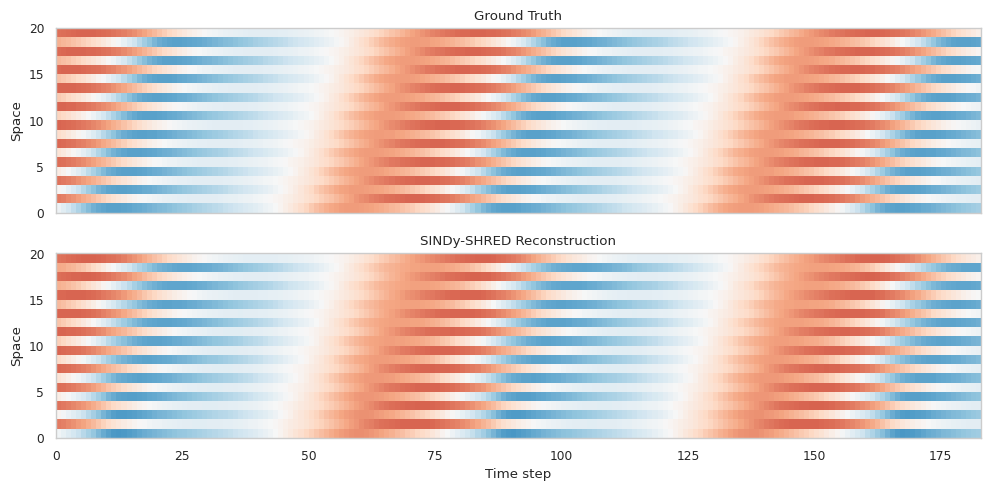

In [14]:
# Visualize reconstruction
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

ax = axes[0]
ax.pcolormesh(test_ground_truth.T, **pcolor_kwargs)
ax.set_title("Ground Truth")
ax.set_ylabel("Space")

ax = axes[1]
ax.pcolormesh(test_recons.T, **pcolor_kwargs)
ax.set_title("SINDy-SHRED Reconstruction")
ax.set_ylabel("Space")
ax.set_xlabel("Time step")

fig.tight_layout()

# Save the reconstruction comparison plot
fig.savefig(f"{RESULTS_DIR}/reconstruction_comparison.pdf", bbox_inches="tight", dpi=300)
fig.savefig(f"{RESULTS_DIR}/reconstruction_comparison.png", bbox_inches="tight", dpi=300)
print(f"Saved reconstruction comparison plot to {RESULTS_DIR}/reconstruction_comparison.pdf")

plt.show()

### Sensor-Level Predictions

Compare real vs predicted at individual spatial locations (sensors).

SINDy prediction shape: (183, 2)
Decoded physical shape: (183, 20)
Saved sensor predictions plot to results/synthetic_data/sensor_predictions_grid.pdf


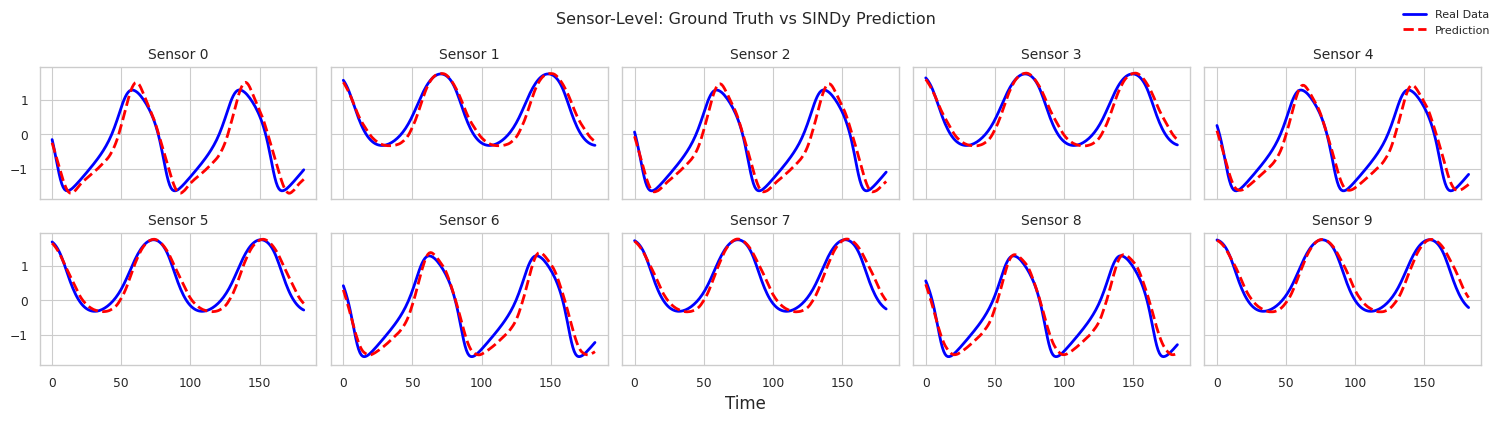

In [15]:
# Predict latent trajectories using SINDy model and decode to physical space
x_predict = model.predict_latent()  # SINDy prediction in latent space
sindy_physical = model.decode_to_physical(x_predict)  # Decode to physical space
sindy_physical = model._scaler.inverse_transform(sindy_physical)  # Unscale

print(f"SINDy prediction shape: {x_predict.shape}")
print(f"Decoded physical shape: {sindy_physical.shape}")

# Plot sensor-level comparisons: Ground Truth vs SINDy Prediction
fig, axes = plotting.plot_sensor_predictions(
    test_ground_truth,
    sindy_physical[:len(test_ground_truth)],
    sensor_locations=np.arange(n_space_dims),  # All spatial dims
    rows=2,
    cols=5,
    save_path=f"{RESULTS_DIR}/sensor_predictions_grid.pdf"
)
fig.suptitle("Sensor-Level: Ground Truth vs SINDy Prediction")
fig.tight_layout()
print(f"Saved sensor predictions plot to {RESULTS_DIR}/sensor_predictions_grid.pdf")
plt.show()

## Summary

This notebook demonstrated SINDy-SHRED on synthetic FitzHugh-Nagumo data:

1. Generated toy data from FitzHugh-Nagumo model with spatial delays
2. Used the `SINDySHRED` class for streamlined model training
3. Discovered sparse governing equations that approximate the true dynamics
4. Achieved accurate reconstruction on held-out test data
5. **Saved all results** to the `results/synthetic_data/` folder

### Saved Files

| File | Description |
|------|-------------|
| `latent_train.npy` | Latent trajectories from training data |
| `latent_test.npy` | Latent trajectories from test data |
| `latent_sindy_predict.npy` | SINDy-predicted latent trajectories |
| `sindy_coefficients.npy` | Learned SINDy coefficient matrix |
| `sindy_feature_names.txt` | Names of SINDy library terms |
| `config.json` | Model configuration and hyperparameters |
| `results.json` | All error metrics (reconstruction, SINDy latent, SINDy prediction) |
| `*.pdf/*.png` | Visualization plots |

The `SINDySHRED` class simplifies the workflow compared to manual data preprocessing and model setup.

## 6. Save Results

Save the trained model, latent space values, and learned SINDy model to the results folder.

In [16]:
import json
from io import StringIO
import sys

# Get latent space trajectories
gru_outs_train = model.gru_normalize(data_type="train")
gru_outs_train_np = gru_outs_train.detach().cpu().numpy()

gru_outs_test = model.gru_normalize(data_type="test")
gru_outs_test_np = gru_outs_test.detach().cpu().numpy()

# Save latent space trajectories
np.save(f"{RESULTS_DIR}/latent_train.npy", gru_outs_train_np)
np.save(f"{RESULTS_DIR}/latent_test.npy", gru_outs_test_np)
np.save(f"{RESULTS_DIR}/latent_sindy_predict.npy", x_predict)
print(f"Saved latent trajectories to {RESULTS_DIR}/latent_*.npy")

# Save SINDy model coefficients
sindy_coefficients = model._model.coefficients()
np.save(f"{RESULTS_DIR}/sindy_coefficients.npy", sindy_coefficients)
print(f"Saved SINDy coefficients to {RESULTS_DIR}/sindy_coefficients.npy")
print(f"SINDy coefficients shape: {sindy_coefficients.shape}")

# Save SINDy feature names
feature_names = model._model.get_feature_names()
with open(f"{RESULTS_DIR}/sindy_feature_names.txt", "w") as f:
    for name in feature_names:
        f.write(name + "\n")
print(f"Saved SINDy feature names to {RESULTS_DIR}/sindy_feature_names.txt")

# Save SINDy equations
old_stdout = sys.stdout
sys.stdout = StringIO()
model._model.print()
equations_str = sys.stdout.getvalue()
sys.stdout = old_stdout

with open(f"{RESULTS_DIR}/sindy_equations.txt", "w") as f:
    f.write("Discovered SINDy Equations:\n")
    f.write("=" * 40 + "\n")
    f.write(equations_str)
print(f"Saved SINDy equations to {RESULTS_DIR}/sindy_equations.txt")

# Save configuration as JSON
config = {
    "latent_dim": latent_dim,
    "poly_order": poly_order,
    "num_sensors": num_sensors,
    "lags": lags,
    "train_length": train_length,
    "validate_length": validate_length,
    "dt": dt,
    "threshold": threshold,
    "best_threshold": float(best_threshold),
}
with open(f"{RESULTS_DIR}/config.json", "w") as f:
    json.dump(config, f, indent=2)
print(f"Saved configuration to {RESULTS_DIR}/config.json")

# Compute additional errors for results
# SINDy latent prediction error (training data)
x_sim = model._x_sim
z = model._gru_outs
sindy_latent_error = np.linalg.norm(x_sim - z[:len(x_sim)]) / np.linalg.norm(z[:len(x_sim)])

# SINDy physical prediction error (test data, use min length to handle shape mismatch)
n_compare = min(len(sindy_physical), len(test_ground_truth))
sindy_physical_error = np.linalg.norm(sindy_physical[:n_compare] - test_ground_truth[:n_compare]) / np.linalg.norm(test_ground_truth[:n_compare])

# Save results as JSON
results = {
    "reconstruction_error": float(relative_error),
    "sindy_latent_error": float(sindy_latent_error),
    "sindy_prediction_error": float(sindy_physical_error),
}
with open(f"{RESULTS_DIR}/results.json", "w") as f:
    json.dump(results, f, indent=2)
print(f"Saved results to {RESULTS_DIR}/results.json")

# Print summary of saved files
print("\n" + "="*50)
print("Saved files summary:")
print("="*50)
for f in sorted(os.listdir(RESULTS_DIR)):
    fpath = os.path.join(RESULTS_DIR, f)
    size = os.path.getsize(fpath)
    print(f"  {f}: {size/1024:.1f} KB")

Saved latent trajectories to results/synthetic_data/latent_*.npy
Saved SINDy coefficients to results/synthetic_data/sindy_coefficients.npy
SINDy coefficients shape: (2, 10)
Saved SINDy feature names to results/synthetic_data/sindy_feature_names.txt
Saved SINDy equations to results/synthetic_data/sindy_equations.txt
Saved configuration to results/synthetic_data/config.json
Saved results to results/synthetic_data/results.json

Saved files summary:
  config.json: 0.2 KB
  data_original.pdf: 37.1 KB
  data_original.png: 73.9 KB
  latent_comparison.pdf: 19.1 KB
  latent_comparison.png: 185.5 KB
  latent_sindy_predict.npy: 3.0 KB
  latent_test.npy: 1.5 KB
  latent_train.npy: 1.6 KB
  reconstruction_comparison.pdf: 46.0 KB
  reconstruction_comparison.png: 97.7 KB
  results.json: 0.1 KB
  sensor_predictions_grid.pdf: 34.1 KB
  sindy_coefficients.npy: 0.3 KB
  sindy_equations.txt: 0.2 KB
  sindy_feature_names.txt: 0.0 KB
